### Lecture 2, Implementing an auto-correlation based fundamental frequency detection algorithm:

In this example, you will be implementing a simple auto-correlation based fundamental frequency estimator. 

Your parts are in cell 2 and marked with labels: #Your code starts here ... #Your code ends here


In [1]:
import os
from essentia.standard import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import get_window

In the cell below, you are expected to implement an auto-correlation based fundamental frequency detector as explained in the lecture. 

The [autocorrelation](http://en.wikipedia.org/wiki/Autocorrelation) , $r_k$, of a signal $x$ at lag $k$ is defined as:

$$ r_k = \sum_n x[n] x[n+k] $$
which is basically a dot product of the signal with its shifted version

In [2]:
def estimateF0_autoCorr(x_win, fs, minF0, maxF0):
    '''F0 detection on a single frame using autocorrelation
    Parameters
    ----------
    x_win : numpy.array
        Windowed signal frame
    fs,minF0,maxF0 : int
        Sampling rate, minimum and maximum F0 limits
        
    Returns
    -------
    f0 : float
        Estimated f0 
    ''' 
    f0 = 0
    minT0 = int(fs/maxF0)
    maxT0 = int(fs/minF0)
    #Your code starts here
    maxValAC = -1;T0 = -1
    for k in range(minT0, maxT0):
        x_win_shifted = np.hstack((np.zeros(k),x_win[:-k]))
        autoCorr = np.dot(x_win,x_win_shifted)
        if autoCorr > maxValAC:
            T0 = k
            maxValAC = autoCorr
    f0 = float(fs) / T0
    #Your code ends here
    return f0

In [3]:
#Setting parameters and reading the wave file
soundsDir = '../data/baris/'
fileName = os.path.join(soundsDir, 'eh.wav')
fs = 44100
minF0 = 50 #in Hz
maxF0 = 2000 #in Hz
windowSize = 4096
hopSize = 1024
w = get_window('blackman', windowSize)
x = MonoLoader(filename = fileName, sampleRate = fs)()
startIndexes = np.arange(0, x.size - windowSize, hopSize, dtype = int)
numWindows = startIndexes.size

In [4]:
#F0 estimation for each window takes place here
f0 = np.zeros_like(startIndexes,dtype=float)#initializing the array for f0 values
for k in range(numWindows):#framing/windowing
    x_win = x[startIndexes[k] : startIndexes[k] + windowSize]*w#window applied here
    f0[k] = estimateF0_autoCorr(x_win, fs, minF0, maxF0)

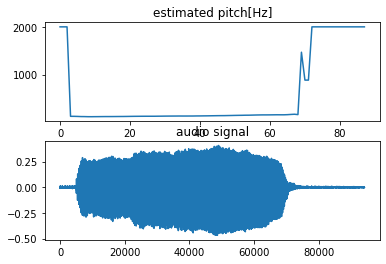

In [5]:
#Plotting the estimated f0 values
f, axarr = plt.subplots(2)
axarr[0].plot(f0)
axarr[0].set_title('estimated pitch[Hz]')
axarr[1].plot(x)
axarr[1].set_title('audio signal')
plt.show()

Clearly, there are regions where f0 estimation makes very large errors. Why? How could we get rid of those unreliable estimates?

Well, there are unpitched parts of the signal and estimating frequency for such frames would return some values. Maybe better to assign them a value indicating that frame is aperiodic, like for example f0=0. We can use another measure of periodicity for that operation like zero-crossing rate. Or, for some cases it would make sense to discard frames with low energy. Let's compute those descriptors, align with f0 data and decide. 

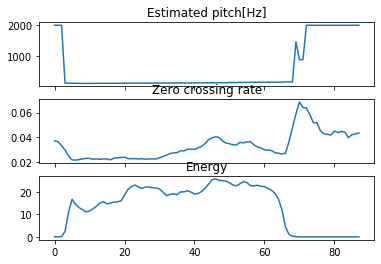

In [6]:
#Computation of zero-cross rates and energy for the same windows
zcr = np.zeros_like(f0,dtype = float)
NRG = np.zeros_like(f0,dtype = float)
for k in range(numWindows):
    x_win = x[startIndexes[k]:startIndexes[k] + windowSize] * w
    NRG[k] = np.sum(np.power(x_win,2))
    #computing zer-crossing rate
    signX = np.sign(x_win)
    diffSign = signX[1:]-signX[:-1]
    zcr[k] = (np.count_nonzero(diffSign) / float(x_win.size))

f, axarr = plt.subplots(3,sharex = True)
axarr[0].plot(f0)
axarr[0].set_title('Estimated pitch[Hz]')
axarr[1].plot(zcr)
axarr[1].set_title('Zero crossing rate')
axarr[2].plot(NRG)
axarr[2].set_title('Energy')
plt.show()

Let's use energy for filtering the f0 estimates

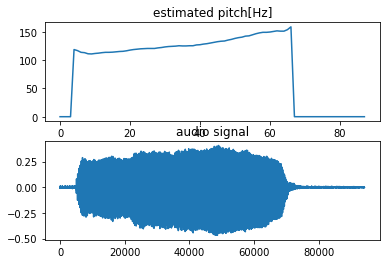

In [7]:
f0[NRG < np.max(NRG)*0.1]=0#manually set threshold for NRG as ratio(0.1) of its maximum value
f, axarr = plt.subplots(2)
axarr[0].plot(f0)
axarr[0].set_title('estimated pitch[Hz]')
axarr[1].plot(x)
axarr[1].set_title('audio signal')
plt.show()

Let's now save the f0 array in a file which could be further uploaded in Sonic visualizer to plot together with spectrogram. We can print (time(seconds),frequency(Hz)) information in a text file.

In [8]:
fileNameF0 = fileName.replace('.wav','.f0_autoCorr.txt')
with open(fileNameF0, 'w') as f:
    for k in range(numWindows):
        time = (startIndexes[k] + windowSize/2)/fs
        f.write(str(time) + '\t' + str(f0[k])+'\n')

The parameters used in analysis will be influential on the results. Experiment with different values of minF0, maxF0, windowSize and observe the results

For another example using Librosa and Numpy functions, refer to https://github.com/stevetjoa/stanford-mir/blob/gh-pages/autocorrelation.ipynb